In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display, Markdown
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install sentence_transformers annoy scikit-learn

# Load necessary libraries
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib


In [ ]:

# # Load the data into pandas dataframes
topics_df = pd.read_csv('/content/drive/MyDrive/curriculam_Content_data/topics.csv', index_col=0).fillna({"title": "", "description": ""})
topics_df = topics_df[topics_df['language'] == 'en']
content_df = pd.read_csv('/content/drive/MyDrive/curriculam_Content_data/content.csv', index_col=0).fillna("")
content_df = content_df[content_df['language'] == 'en']
correlations_df = pd.read_csv('/content/drive/MyDrive/curriculam_Content_data/correlations.csv', index_col=0)

# Filter topics that have content
topics_df = topics_df[topics_df['has_content']]

In [ ]:
# Define helper functions and classes
class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" >> ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"

class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

In [ ]:
# Initialize the sentence transformer model
model = SentenceTransformer("all-mpnet-base-v2")
# Using different models for comparison
# model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
# model = SentenceTransformer("all-MiniLM-L6-v2")
# model = SentenceTransformer("paraphrase-MiniLM-L6-v2")


Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:

# Embedding topics
print("Embedding topics...")
topic_embeddings = model.encode([f"{row['title']} - {row['description']}" for idx, row in topics_df.iterrows()])

# Embedding content
print("Embedding content...")
content_embeddings = model.encode([row['title'] for idx, row in content_df.iterrows()])

Embedding topics...


Batches:   0%|          | 0/877 [00:00<?, ?it/s]

Embedding content...


Batches:   0%|          | 0/2061 [00:00<?, ?it/s]

In [ ]:


# Prepare data for training
X = np.vstack((topic_embeddings, content_embeddings))
y = np.concatenate((np.ones(len(topic_embeddings)), np.zeros(len(content_embeddings))))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM classifier
svm_model = SVC(kernel='linear')

# Train the model
print("Training SVM model...")
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Training SVM model...
Accuracy: 0.9038246715250812
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93     13262
         1.0       0.90      0.76      0.82      5537

    accuracy                           0.90     18799
   macro avg       0.90      0.86      0.88     18799
weighted avg       0.90      0.90      0.90     18799

Confusion Matrix:
[[12809   453]
 [ 1355  4182]]


In [ ]:
!pip install matplotlib seaborn
import seaborn as sns


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.9038246715250812


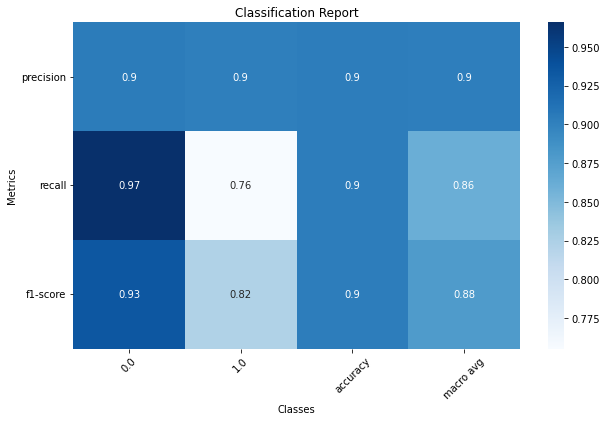

In [ ]:

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert evaluation results to tables
def plot_classification_report(report):
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Topic'], yticklabels=['Content', 'Topic'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

print(f'Accuracy: {accuracy}')
plot_classification_report(report_dict)

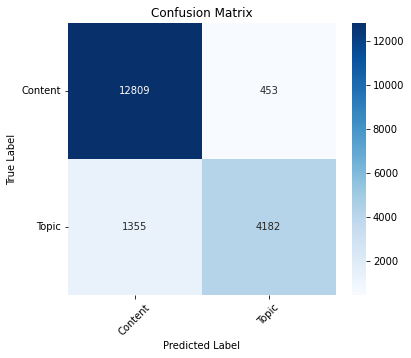

In [ ]:
plot_confusion_matrix(conf_matrix)

In [ ]:
# Save the trained model to a file
joblib.dump(svm_model, 'svm_model.joblib')

# Load the trained model
svm_model = joblib.load('svm_model.joblib')

In [ ]:
# Define recommendation function using SVM
def recommend_content(topic_id, svm_model, model):
    # Get the embedding for the given topic_id
    topic_embedding = model.encode(f"{topics_df.loc[topic_id]['title']} - {topics_df.loc[topic_id]['description']}")

    # Calculate distances between the topic embedding and all content embeddings
    distances = np.linalg.norm(content_embeddings - topic_embedding, axis=1)

    # Get the indices of the closest content
    top_indices = np.argsort(distances)[:10]  # Top 10 recommendations
    recommended_content_ids = content_df.index[top_indices].tolist()

    return recommended_content_ids

# Example usage
def run_recommendation(topic_id):
    recommended_content = recommend_content(topic_id, svm_model, model)
    if recommended_content:
        print(f"Recommended content for Topic ID {topic_id}:")
        print("Topic title:", topics_df.loc[topic_id]["title"])
        print("Recommendations:")
        recommendations = []
        for content_id in recommended_content:
            recommendations.append([content_id, content_df.loc[content_id]['title']])
            print(f"Content ID: {content_id}, Title: {content_df.loc[content_id]['title']}")
        return recommendations
    else:
        print(f"No recommendations available for Topic ID {topic_id}")
        return []

# Example usage
recommendations = run_recommendation('t_00069b63a70a')  # Replace with an actual topic_id from your dataset



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Recommended content for Topic ID t_00069b63a70a:
Topic title: Transcripts
Recommendations:
Content ID: c_942b454ca508, Title: Amount of Substance ..: Written Transcript part 2 of 2
Content ID: c_c4b6db8b5c7d, Title: Amount of Substance ..: Written Transcript part 1 of 2
Content ID: c_d0967bfa2fb2, Title: 2.8: Playgrounds and Transcripts
Content ID: c_430ddb6fbfa4, Title: Transcription
Content ID: c_07e16f3aabbf, Title: Transcription
Content ID: c_2359fa003e04, Title: Choosing a College R..: Written Transcript of this video lesson
Content ID: c_89dee4e1d740, Title: Lecture 18: Transcription
Content ID: c_fac629ee0e31, Title: Part 3: Transcription
Content ID: c_8361130de2a0, Title: 9.3: Transcription
Content ID: c_ff82a1f8599c, Title: 5.3: Transcription
